## NMT English to Chinese

## 載入torch 0.6.0


In [1]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 5.0MB/s 
     |████████████████████████████████| 1.2MB 10.8MB/s 
  Found existing installation: torchtext 0.9.0
    Uninstalling torchtext-0.9.0:
      Successfully uninstalled torchtext-0.9.0


## 匯入package

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.data import Field, BucketIterator, TabularDataset
from sklearn.model_selection import train_test_split
import csv

import numpy as np
import re
import random
import math
import time

import csv
import spacy

In [3]:
!pip install matplotlib

In [4]:

# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載字體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.7/dist-packages/matplotlib//mpl-data/fonts/ttf

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt 
plt.style.use("seaborn-whitegrid")
import matplotlib.ticker as ticker
# 自定義字體變數
myfont = FontProperties(fname=r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')

--2021-03-24 15:28:31--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.137.139, 74.125.137.100, 74.125.137.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.137.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/huib3mjv9bh3j09dqcfs92jaa9h9o0or/1616599650000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-03-24 15:28:33--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/huib3mjv9bh3j09dqcfs92jaa9h9o0or/1616599650000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 172.217.3.33, 2607:f8b0:4026:801::2001
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|172.21

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_dir = '/content/drive/My Drive/data/'
lines = open(data_dir + 'cmn.txt' , encoding='utf-8').read().strip().split('\n')
trnslt_pairs = [[s for s in l.split('\t')] for l in lines ]
print ("Sample: " , trnslt_pairs[1000][:2] )
print ("Total records:" , len(trnslt_pairs))

Sample:  ['He was drowned.', '他被淹死了。']
Total records: 24360


In [7]:
# create train and validation set

print ("Total records after filtering :" , len(trnslt_pairs))
train, test = train_test_split(trnslt_pairs, test_size=0.1)
train, val = train_test_split(train, test_size=0.1)
print ("training data:{} , develop data: {} , testing data: {}".format(len(train),len(val),len(test)))
    
def write_csv(trn_data, file_path ):
    with open(file_path ,'w', newline='', encoding='utf-8') as fout:
        writer = csv.writer (fout)
        for itm in trn_data: 
            writer.writerow ([itm[0],itm[1]])
            
file_path = data_dir + 'train.csv'
write_csv(train, file_path )

file_path = data_dir + 'val.csv'
write_csv(val, file_path )
    
file_path = data_dir + 'test.csv'
write_csv(test, file_path )

Total records after filtering : 24360
training data:19731 , develop data: 2193 , testing data: 2436


In [8]:
# 下載 spacy 的英文模型 幫我們做tokenize
spacy_eng = spacy.load('en_core_web_sm')
def tokenize_eng(text):
  #清除不需要的字符
  text = re.sub(r"([.!?])", r" \1", text)
  return [tok.text for tok in spacy_eng.tokenizer(text)]

def tokenize_cmn(text):
  #去掉非中文字元
  regex = re.compile(r'[^\u4e00-\u9fa5A-Za-z0-9]')
  text = regex.sub(' ', text)

  return [word for word in text if word.strip()]


TRG = Field(tokenize = tokenize_eng, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

SRC = Field(tokenize = tokenize_cmn, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

In [9]:
# 讀取csv用TabularDataset
train_dataset, dev_dataset, test_dataset = TabularDataset.splits(
    path = data_dir , format = 'csv', skip_header = True,
    train='train.csv', validation='val.csv', test='test.csv',
    fields=[
        ('trg', TRG),
        ('src', SRC)
    ]
)
SRC.build_vocab(train_dataset, min_freq = 1)
TRG.build_vocab(train_dataset, min_freq = 1)

print ("中文語料的字元表長度: " , len(SRC.vocab) , ", 英文的字元表長度: " ,len(TRG.vocab))

中文語料的字元表長度:  3349 , 英文的字元表長度:  6093


In [10]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, dev_dataset, test_dataset), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

* encoder_outputs 就是input每個hidden的輸出 假設有此句有4個詞，hidden dim為32 batch_size 為 2 那就是[4, 2, 32*2(bidirect
)]
* hidden 因為是要餵給decoder，所以用的是decoder的大小，此題是encode_hidden的2倍[2, 64]
* mask 之後補

In [ ]:
class Attention(nn.Module):
  def __init__(self, enc_hid_dim, dec_hid_dim):
    super().__init__()

  def forward(self, hidden, encoder_outputs, mask):
    # hidden bz , dec_hid_dim
    # encoder_outputs src len, bz , enc_hid_dim x 2
    # mask bz , src len
    
    batch_size = encoder_outputs.shape[1]
    src_len = encoder_outputs.shape[0]

    hidden = hidden.unsqueeze(1) 
    # hidden unsqueeze bz , 1 , dec_hid_dim

    attention = torch.matmul( hidden , encoder_outputs.permute(1, 2, 0))
    # attention bz, 1 , src len
    
    attention = attention.squeeze(1)
    # squeeze bz , src len

    attention = attention.masked_fill(mask == 0, -1e10)

    return F.softmax(attention, dim = 1)

In [ ]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        """
        input_dim: 3349
        emb_dim: 300
        enc_hid_dim: 256
        dec_hid_dim: 512
        dropout: 0.5
        """
        # 我們的例子:[3349, 300]
        self.embedding = nn.Embedding(input_dim, emb_dim)

        # 雙向 ＧＲＵ  [300, 1, 256*2]
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        # [512, 512]
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        """
        src: [src len, batch size]  包起來的樣子[每一個batch的max_src_len, batch_szie]
        src_len: [batch size]
        """

        # [src len, batch size, emb dim]
        embedded = self.dropout(self.embedding(src))
        
                
        # 使用pack_padded_sequence 來壓縮序列        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
                
        packed_outputs, hidden = self.rnn(packed_embedded)

        # 使用 pad_packed_sequence 用來展開序列成原本形狀的      
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
            
        #outputs shape [src len, batch size, hid dim * num directions]
        #hidden shape [n layers * num directions, batch size, hid dim]
        
        #hidden 堆疊 [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs 是最後一層 
        
        #hidden [-2, :, : ] 是最後一層 forwards RNN 
        #hidden [-1, :, : ] 是最後一層 backwards RNN
        
        # hidden 是最後再過一層 dense layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs shape [src len, batch size, enc hid dim * 2]
        #hidden shape [batch size, dec hid dim]
        
        return outputs, hidden

In [ ]:
class RNNDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        # 單向 ＧＲＵ decoder 
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        # 512 + 512 + 256
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input shape [batch size]
        #hidden shape [batch size, dec hid dim]
        #encoder_outputs shape [src len, batch size, enc hid dim * 2]
        #mask shape [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input shape [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded shape [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a shape [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a shape [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs shape [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted shape [batch size, 1, enc hid dim * 2]
        # a * value
        weighted = weighted.permute(1, 0, 2)
        
        #weighted shape [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input shape [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output shape [seq len, batch size, dec hid dim * n directions]
        #hidden shape [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output shape [1, batch size, dec hid dim]
        #hidden shape [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction shape [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [ ]:
class Seq2SeqATTN(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 256 # 注意 encoder hidden layer 設定 必須為 dec 的一半 
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

LEARNING_RATE = 0.001

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = RNNEncoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = RNNDecoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = Seq2SeqATTN(enc, dec, SRC_PAD_IDX, device).to(device)

optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


def initial_mdl_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(initial_mdl_weights)
print ("模型全部參數量: {:10,d} ".format(sum(p.numel() for p in model.parameters())))
model

模型全部參數量: 13,330,946 


Seq2SeqATTN(
  (encoder): RNNEncoder(
    (embedding): Embedding(3372, 256)
    (rnn): GRU(256, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): RNNDecoder(
    (attention): Attention()
    (embedding): Embedding(6146, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=6146, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len.cpu() , trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len.cpu(), trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
MAX_EPOCHS = 30
CLIP = 2
model_dir =  '/content/drive/My Drive/data/'
best_valid_loss = 9999999

for epoch in range(MAX_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    torch.save(model.state_dict(), model_dir + 'model-{}.pt'.format(epoch))
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_dir + 'best-model.pt')
   
    print ("Epoch {} training time: {:.2f} sec Training Loss: {:.3f} , Valiation Loss: {:.3f}".format( epoch , end_time - start_time , train_loss , valid_loss))

Epoch 0 training time: 483.81 sec Training Loss: 5.450 , Valiation Loss: 5.013
Epoch 1 training time: 483.13 sec Training Loss: 4.496 , Valiation Loss: 4.670
Epoch 2 training time: 479.65 sec Training Loss: 4.068 , Valiation Loss: 4.495
Epoch 3 training time: 476.80 sec Training Loss: 3.714 , Valiation Loss: 4.251
Epoch 4 training time: 474.63 sec Training Loss: 3.401 , Valiation Loss: 4.112
Epoch 5 training time: 479.53 sec Training Loss: 3.083 , Valiation Loss: 3.936
Epoch 6 training time: 482.56 sec Training Loss: 2.804 , Valiation Loss: 3.848
Epoch 7 training time: 478.16 sec Training Loss: 2.557 , Valiation Loss: 3.749
Epoch 8 training time: 480.75 sec Training Loss: 2.314 , Valiation Loss: 3.697
Epoch 9 training time: 473.89 sec Training Loss: 2.132 , Valiation Loss: 3.682
Epoch 10 training time: 471.48 sec Training Loss: 1.946 , Valiation Loss: 3.658
Epoch 11 training time: 477.10 sec Training Loss: 1.781 , Valiation Loss: 3.632
Epoch 12 training time: 472.65 sec Training Loss: 

KeyboardInterrupt: ignored

In [ ]:
# Save SRC and TRG vocab
torch.save(SRC.vocab, model_dir + 'SRC_vocab.pt')
torch.save(TRG.vocab, model_dir + 'TRG_vocab.pt')

In [ ]:
model.load_state_dict(torch.load(model_dir + 'best-model.pt'))
#model.load_state_dict(torch.load(model_dir + 'model-7.pt'))
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.729 | Test PPL:  41.638 |


In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    #if isinstance(sentence, str):
    #    nlp = spacy_en = spacy.load('en_core_web_sm')
    #    tokens = [token.text.lower() for token in spacy_en(sentence)]
    #else:
    #    tokens = [token.lower() for token in sentence]

    tokens = [token.lower() for token in sentence]
        
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len.cpu())

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [ ]:
example_idx =520

src = vars(train_dataset.examples[example_idx])['src']
trg = vars(train_dataset.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

src = ['她', '企', '圖', '自', '殺']
trg = ['she', 'tried', 'to', 'kill', 'herself', '.']
predicted trg = ['she', 'tried', 'to', 'kill', 'herself', '.', '<eos>']


In [ ]:

from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_dataset, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 17.48


In [ ]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    #fontdict = {"fontproperties": zhfont}
    
    #ax.set_xticks(range(max(max_len_tar, len(predicted_seq))))
    #ax.set_xlim(-0.5, max_len_tar -1.5)
    
    #ax.set_yticks(range(len(sentence) + 2))
    #ax.set_xticklabels([subword_encoder_zh.decode([i]) for i in predicted_seq 
    #                    if i < subword_encoder_zh.vocab_size], 
    #                   fontdict=fontdict, fontsize=18)
    
    #plt.rcParams["font.family"]="sans-serif"
    #plt.rcParams['font.sans-serif']=['STSong'] #用来正常显示中文标签
    
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45 , fontproperties=myfont) #, fontdict=fontdict)
    ax.set_yticklabels(['']+translation, fontproperties=myfont) # , fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
# 請在這邊自行調整 sample index 
# 觀察不同句子的 ATTENTION 結果
example_idx =70

src = vars(train_dataset.examples[example_idx])['src']
trg = vars(train_dataset.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

src = ['能', '让', '我', '用', '这', '个', '吗']
trg = ['am', 'i', 'allowed', 'to', 'use', 'this', '?']
predicted trg = ['can', 'i', 'have', 'this', 'this', '?', '<eos>']


能让我用这个吗


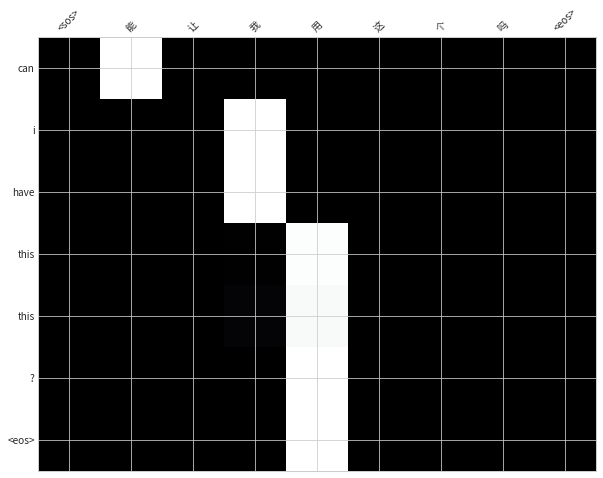

In [ ]:
print ("".join(src ))
display_attention(src, translation, attention)